# Computer Vision
16/11/2021   
read images from video and analyse them.

In [21]:
%pylab inline
import pandas
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


C:\Users\buein\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['histogram', 'hist', 'gray']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## convert video to frames

In [4]:
vidcap = cv2.VideoCapture('../../videos/Odor 1 .avi')
success,image = vidcap.read()
os.mkdir("../../videos/frames1")

In [5]:
count = 0
while success:
  cv2.imwrite("../../videos/frames1/Odor1_frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  # print('Read a new frame: ', success)
  count += 1

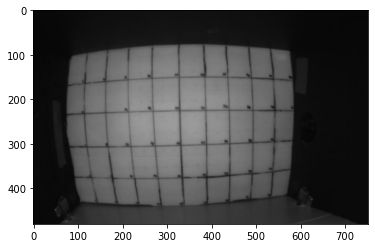

In [6]:
# importing matplotlib modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
  
# Read Images
imagename = '../../videos/frames1/Odor1_frame1.jpg'
img = mpimg.imread(imagename)
  
# Output Images
plt.imshow(img)

In [7]:
img = cv2.imread('../../videos/frames1/Odor1_frame1.jpg')
cv2.imshow('image', img) 

## very initial code
mainly taken from [here](https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/)

In [8]:
# import the necessary packages
from imutils.video import VideoStream
import argparse
import datetime
import imutils
import time
import cv2

In [9]:
args = {}
args['min_area'] = 0.1

In [10]:
vs = cv2.VideoCapture('../../videos/Odor 1 .avi')
firstFrame = None
frame_num = 0
rat_rects = {}

# loop over the frames of the video
while True:
	# grab the current frame and initialize the occupied/unoccupied text
	frame = vs.read()[1]
	frame_num += 1
	# if the frame could not be grabbed, then we have reached the end of the video
	if frame is None:
		break
	# resize the frame, convert it to grayscale, and blur it
	frame = imutils.resize(frame, width=500)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	gray = cv2.GaussianBlur(gray, (21, 21), 0)
 
	# if the first frame is None, initialize it
	if firstFrame is None:
		firstFrame = gray
		continue

	# compute the absolute difference between the current frame and
	# first frame
	frameDelta = cv2.absdiff(firstFrame, gray)
	thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]

	# dilate the thresholded image to fill in holes, then find contours on thresholded image
	thresh = cv2.dilate(thresh, None, iterations=2)
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
 
	# loop over the contours
	for c in cnts:
		# if the contour is too small, ignore it
		if cv2.contourArea(c) < args["min_area"]:
			continue
		# compute the bounding box for the contour
		(x, y, w, h) = cv2.boundingRect(c)
		rat_rects[frame_num] = {'x': x, 'y': y, 'w': w, 'h': h}
	
# cleanup the camera and close any open windows
vs.release()
cv2.destroyAllWindows()

<AxesSubplot:xlabel='x', ylabel='y'>

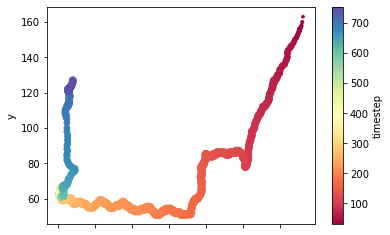

In [11]:
raw_data = pandas.DataFrame(rat_rects).T
raw_data.index.name = 'timestep'
raw_data.reset_index().plot.scatter(x='x', y='y', s='w', c='timestep', cmap='Spectral')

You can see the point where the rat stayed quite a bit.   
You can use this info for a lot of stuff, such as calculating the rat's velocity, guessing whether it found the drop or didn't...

The next thing I want to do: narrow down the location of the rat into a much smaller area. I will start by getting the exact position of the rectangle and anlysing it. Also, I want to properly model the background so that I could tell in each point in time in which rectangle the rat is.

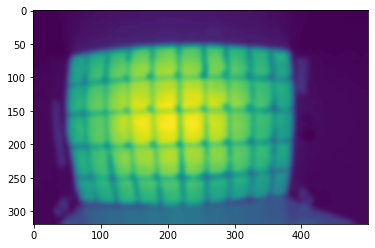

In [12]:
plt.imshow(firstFrame)

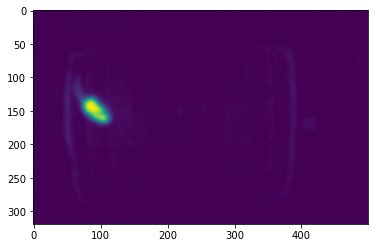

In [13]:
plt.imshow(frameDelta)

## Scikit-Image

In [23]:
from skimage import data
from skimage.exposure import histogram
from skimage.filters import sobel
from scipy import ndimage as ndi
from skimage.segmentation import watershed

In [24]:
# the upcoming code is fully explained here: https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html
coins = data.coins()
hist, hist_centers = histogram(coins)

elevation_map = sobel(coins)
# markers: say if the pixel is background or data
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

In [25]:
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)


In [26]:
labeled_coins

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

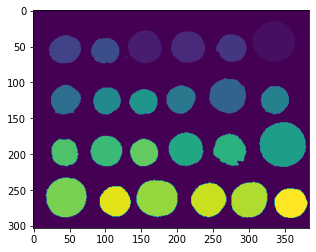

In [27]:
plt.imshow(labeled_coins)

#### try it on my images

In [59]:
# Read Images
from skimage.color import rgb2gray
imagename = '../../videos/frames1/Odor1_frame100.jpg'


In [97]:
img = mpimg.imread(imagename)
coins = rgb2gray(img) * 255. / img.max()
coins *= 255

In [121]:
edges = canny(coins)
fill_coins = ndi.binary_fill_holes(edges)
coins_cleaned = morphology.remove_small_objects(fill_coins, 21)
elevation_map = sobel(coins)
markers = np.zeros_like(coins)
markers[coins < 50] = 1
markers[coins > 80] = 2
segmentation_coins = segmentation.watershed(elevation_map, markers)
segmentation_coins = ndi.binary_fill_holes(segmentation_coins - 1)
labeled_coins, _ = ndi.label(segmentation_coins)
image_label_overlay = label2rgb(labeled_coins, image=coins, bg_label=0)

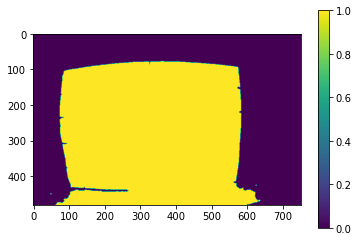

In [122]:
imshow(segmentation_coins)
colorbar()

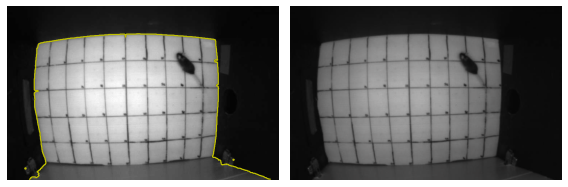

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].contour(segmentation_coins, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay / 255.)

for a in axes:
    a.axis('off')

plt.tight_layout()

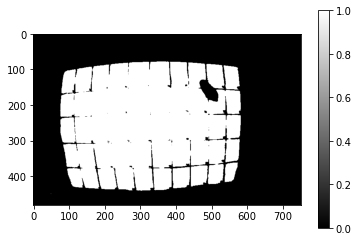

In [ ]:
# we have 3 parts: mouse, backgound and out of box
# this shows only the inside background
# the saparation of mouse from outer thing is more tricky
imshow(imgnorm>110, cmap='gray')
colorbar()

<AxesSubplot:>

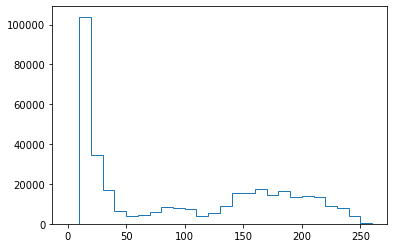

In [75]:
pandas.Series(imgnorm.flatten()).hist(histtype='step', grid=False, bins=arange(0, 261, 10))

In [93]:
elevation_map = sobel(imgnorm)
# markers: say if the pixel is background or data
markers = np.zeros_like(imgnorm)
markers[imgnorm < 30] = 1
markers[imgnorm > 150] = 2

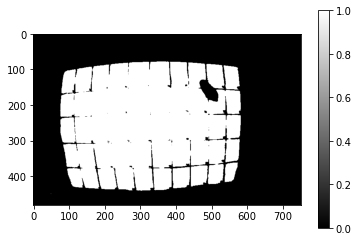

In [92]:
# we have 3 parts: mouse, backgound and out of box
# this shows only the inside background
# the saparation of mouse from outer thing is more tricky
imshow(imgnorm>110, cmap='gray')
colorbar()

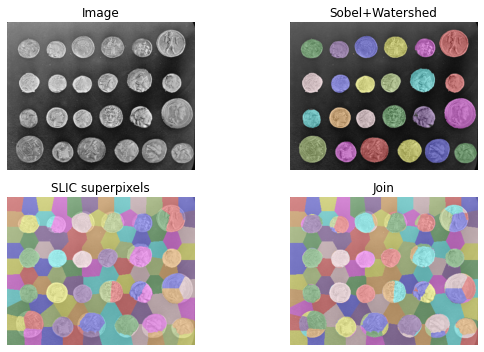

In [130]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations, watershed
from skimage.color import label2rgb
from skimage import data

coins = data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# Make segmentation using SLIC superpixels.
seg2 = slic(coins, n_segments=117, max_num_iter=160, sigma=1, compactness=0.75,
            channel_axis=None, start_label=0)

# Combine the two.
segj = join_segmentations(seg1, seg2)

# Show the segmentations.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 5),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(coins, cmap='gray')
ax[0].set_title('Image')

color1 = label2rgb(seg1, image=coins, bg_label=0)
ax[1].imshow(color1)
ax[1].set_title('Sobel+Watershed')

color2 = label2rgb(seg2, image=coins, image_alpha=0.5, bg_label=-1)
ax[2].imshow(color2)
ax[2].set_title('SLIC superpixels')

color3 = label2rgb(segj, image=coins, image_alpha=0.5, bg_label=-1)
ax[3].imshow(color3)
ax[3].set_title('Join')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

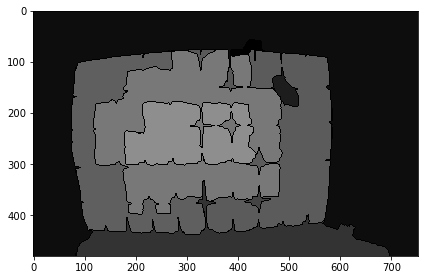

In [133]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


# img = data.coffee()
img = mpimg.imread(imagename)
labels = segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
io.imshow(out)
io.show()

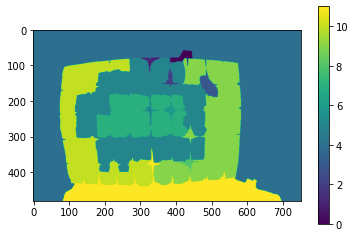

In [138]:
imshow(labels2)
colorbar()

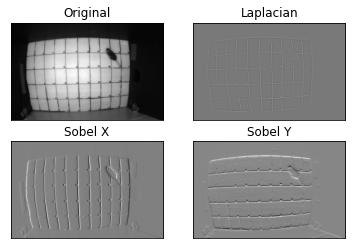

In [150]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread(imagename, 0)
laplacian = cv.Laplacian(img,cv.CV_64F)
sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

In [173]:
import cv2 as cv
import numpy as np
img = cv.imread(cv.samples.findFile(imagename))
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,50,150,apertureSize = 3)
lines = cv.HoughLinesP(edges,1,np.pi/180,100,minLineLength=20,maxLineGap=5)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv.line(img,(x1,y1),(x2,y2),(0,255,0),2)

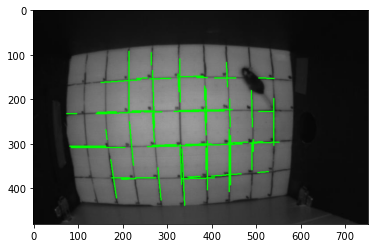

In [174]:
imshow(img)

In [177]:
mh.imread(imagename)

array([[[ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       [[ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       [[ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       ...,

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]]], dtype=uint8)

Found 3 nuclei.


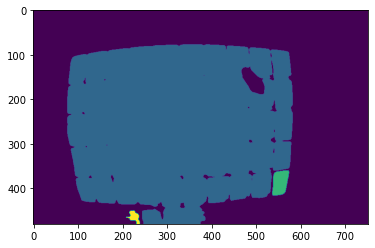

In [181]:
import mahotas as mh
import mahotas.demos
import numpy as np
from pylab import imshow, show

f = mh.imread(imagename) # mh.demos.nuclear_image()
f = f[:,:,0]
f = mh.gaussian_filter(f, 2)
f = (f> f.mean())
labeled, n_nucleus  = mh.label(f)
print('Found {} nuclei.'.format(n_nucleus))
imshow(labeled)
show()
